# BGSE Text Mining Homework 1
### Laura Roman, Veronika Kyuchukova and Euan Dowers
#### April 20, 2017

## Exercise 1
Before starting the text analysis we should pre-process the text, which involves the following steps: 
1. tokenize the data
2. remove non-alphabetic characters, 
3. remove stopwords
4. stem words

Once the data is pre-processed we are in condition to compute the corpus level tf-idf score of every term and choose a cutoff to remove words.

In [1]:
import re
import nltk
import string
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib
from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import porter
from numpy.linalg import svd
from scipy.misc import logsumexp
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

In [2]:
# Read in data; documents defined at the paragraph level
data = pd.read_table("speech_data_extend.txt",encoding="utf-8")
speeches = data['speech']

In [3]:
# PRE-PROCESSING THE DATA
def my_tokeniser(speeches):
    # Tokenize speeches
    tokenizer = RegexpTokenizer(r'\w+')
    sp_tkn = [tokenizer.tokenize(speech) for speech in speeches]
    return sp_tkn

def remove_nonalph(sp_tkn):
    # Remove non-alphabetic tokens
    for i in range(len(sp_tkn)):
        sp_tkn[i] = [j for j in sp_tkn[i] if j[0] in set(string.ascii_letters)]
    return sp_tkn

def stopword_del(sp_tkn):
    # Remove stopwords
    stop = set(stopwords.words('english'))
    for i in range(len(sp_tkn)):
        sp_tkn[i] = [j.lower() for j in sp_tkn[i] if j.lower() not in stop]
    return sp_tkn

def my_stem(sp_tkn):
    # Stem words in documents
    stemmer = porter.PorterStemmer()
    stemmed = [[stemmer.stem(word) for word in doc] for doc in sp_tkn]
    return stemmed

def remove_zerolen_strings(stemmed, data):
    idx = [i for i in range(len(stemmed)) if len(stemmed[i]) == 0]
    stemmed = [i for i in stemmed if len(i) > 0]
    data = data.drop(data.index[idx])
    data = data.reset_index(drop=True)
    #return [stemmed, data]
    return (stemmed, data)

def data_processing(data):
    #Put together all steps in data processing. NOTE data must have column 'speech'
    speeches = data.speech
    sp_tkn = my_tokeniser(speeches)
    sp_tkn = remove_nonalph(sp_tkn)
    sp_tkn = stopword_del(sp_tkn)
    stemmed = my_stem(sp_tkn)
    stemmed, data = remove_zerolen_strings(stemmed, data)
    return (stemmed, data)

In [4]:
# CALCULATING TF-IDF SCORES
def get_vocab(stemmed_data):
    # extracts corpus vocabulary from list of documents
    vocab = list(set().union(*stemmed_data))
    return vocab

def doc_count(stemmed,vocab):
    # counts how many documents each word appears in
    df = dict(zip(vocab,[0]*len(vocab)))
    for i in range(len(stemmed)):
        words = set(stemmed[i])
        for j in words:
            df[j] = df[j]+1
    return df

def make_IDF(stemmed,vocab):
    # Calculates IDF factor for each word in vocabulary
    D   = len(stemmed)
    n   = len(get_vocab(stemmed))
    df  = doc_count(stemmed,vocab)
    IDF = [np.log(D/d) for d in df.values()]
    IDF_dict = dict(zip(vocab,IDF))
    return IDF_dict

def corpus_tf(stemmed):
    # Calculate corpus-level TF scores
    count_matrix = make_count(stemmed)
    tf = 1 +  np.log(np.sum(count_matrix, axis = 0))
    return tf

def corpus_tf_idf(stemmed):
    # Calculate corpus-level TF-IDF scores
    count_matrix = make_count(stemmed)
    vocab = get_vocab(stemmed)
    idf = list(make_IDF(stemmed, vocab).values())
    tf = 1 +  np.log(np.sum(count_matrix, axis = 0))
    tf_idf = tf * idf
    return tf_idf

def custom_stopword_del(stemmed, our_stopwords):
    for i in range(len(stemmed)):
        stemmed[i] = [j.lower() for j in stemmed[i] if j.lower() not in our_stopwords]
    return stemmed

def make_count(stemmed):
    # Constructs docs-terms matrix
    vocab = get_vocab(stemmed)
    D = len(stemmed)
    n = len(vocab)
    idx = dict(zip(vocab,range(len(vocab))))
    count_matrix = np.ndarray(shape=(D,n))

    for i in range(len(stemmed)):
        for j in set(stemmed[i]):
            count_matrix[i,idx[j]] = stemmed[i].count(j)
    return count_matrix

def make_TF_IDF(stemmed):
    # Calculates TF-IDF matrix
    vocab = get_vocab(stemmed)
    D = len(stemmed)
    idx = dict(zip(vocab,range(len(vocab))))
    IDF_dict = make_IDF(stemmed,vocab)
    tf_idf = np.ndarray(shape=(D,len(vocab)))

    for i in range(len(stemmed)):
        for j in set(stemmed[i]):
            tf_idf[i,idx[j]] = stemmed[i].count(j)*IDF_dict[j]
    return tf_idf

In [5]:
# PROCESS THE DATA
stemmed, processed_data = data_processing(data)

#tf scores
vocab = get_vocab(stemmed)
tf_scores = corpus_tf(stemmed)

sort_tf = sorted(tf_scores,reverse=True)
ind_tf = sorted(range(len(tf_scores)), key=lambda k: tf_scores[k],reverse=True)
vocab_s = [vocab[i] for i in ind_tf]

term_sorttf = pd.DataFrame(
    {'term': vocab_s,
    'tf': sort_tf
    })

#tf-idf scores
tf_idf_scores = corpus_tf_idf(stemmed)

sort_tfidf = sorted(tf_idf_scores,reverse=True)
ind_tfidf = sorted(range(len(tf_idf_scores)), key=lambda k: tf_idf_scores[k],reverse=True)
vocab_sidf = [vocab[i] for i in ind_tfidf]
#sorted tf_idf

term_sortfidf = pd.DataFrame(
    {'term': vocab_sidf,
    'tf-idf': sort_tfidf
    })

our_stopwords = set(vocab_sidf[0:2000])

stemmed = custom_stopword_del(stemmed, our_stopwords)
stemmed, processed_data = remove_zerolen_strings(stemmed, processed_data)

In [6]:
print(stemmed[0])
print(processed_data.speech[0])

['fellow']
Fellow-Citizens of the Senate and House of Representatives: 


You can see from the example above the effect of our custom stopword removal, with words such as 'house' and 'senate' obviously context-specific. 


## Exercise 2

Once we have processed the data and formed the document-term matrix, we are ready to perform some analysis that will help us gain insight on the text. In this first part, we will use dictionary methods to describe US presidential speeches over years. 


### 2. a )
We have come up with 7 dictionaries of interest: positive, negative, uncertainty, passive, ethics, politics, economy and military words. We load these lists of words, stem them and clean them by getting rid of ambiguous words. That is, words that appear in more than one dictionary. 

In [7]:
%run dict_cleaning.py

### 2. b)
In order to provide a quantitative representation of each document, we can construct a document-topic matrix where each row is a document and each of the seven columns represents a dictionary or topic, where the (i,j)-th entry represents the number of words classified as topic j in document i.

In [8]:
def count_on_dict(dictionary, words):
    # Calculate counts of a word list based on a dictionary
    recognized_word_count = 0

    words_list = []
    for word in words:
        if word in dictionary:
            recognized_word_count += 1
            words_list.append(word)

    return recognized_word_count, words_list

def docs_dict_matrix(stem,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict ):
    # Computes docs-topics matrix with data arranged by year or by docs
    counts = np.ndarray(shape=(len(stem),8))
    for j in range(len(stem)):
        words = []
        words = stem[j]
        counts[j,0] = count_on_dict(positive_dict,words)[0]
        counts[j,1] = count_on_dict(negative_dict,words)[0]
        counts[j,2] = count_on_dict(uncert_dict,words)[0]
        counts[j,3] = count_on_dict(passive_dict,words)[0]
        counts[j,4] = count_on_dict(ethic_dict,words)[0]
        counts[j,5] = count_on_dict(politic_dict,words)[0]
        counts[j,6] = count_on_dict(econ_dict,words)[0]
        counts[j,7] = count_on_dict(military_dict,words)[0]
        #pos_words = calculate_sentiment_for_word_list(positive_dict,words)[1] # classif words
    
    counts = pd.DataFrame(counts, columns=['pos', 'neg', 'unc', 'passive', 'ethic', 'polit', 'econ', 'milit'])
    counts['total'] = counts.sum(axis=1)
    return counts

And we obtaint the documents-topics matrix (dtm):

In [9]:
dtm = docs_dict_matrix(stemmed,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict )
dtm.shape
dtm

,pos,neg,unc,passive,ethic,polit,econ,milit,total
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,5.0
2,3.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,7.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
6,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,5.0
7,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,7.0
8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0


More illustrative is to show the percentage of the different topics across all documents (whole corpus).  

In [10]:
sum_odocs = dtm.sum(axis=0)
perc = np.ndarray(shape=(8,))
for i in range(8):
    perc[i]=100*sum_odocs[i]/sum_odocs[8]
perc = pd.DataFrame(perc)
perc.columns = ['%']
perc.index =    ['positive', 'negative', 'uncertainty', 'passive', 'ethic', 'politics', 'economy', 'military']
perc.sort_values(by='%', ascending=0)

,%
economy,28.100582
positive,20.128326
passive,17.484257
negative,15.227042
politics,10.975911
uncertainty,2.967015
ethic,2.688378
military,2.428487


On the other hand, we are interested in studying the yearly evolution of the speeches content instead of that for each 
one of the paragraphs (or documents). 

In [11]:
#yearly data processing
data_by_years= pd.DataFrame(processed_data)
data_by_years = data_by_years.groupby('year', sort=False, as_index=True)['speech'].apply(' '.join)
data_by_years = data_by_years.reset_index()
stemmed_y, processed_data_y = data_processing(data_by_years)


And we obtain the year-topics matrix:

In [12]:
yt = docs_dict_matrix(stemmed_y,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict )
yt['year'] =data_by_years['year']
yt.shape

(224, 10)

That can aswell be expressed by percentages:

In [13]:
ytp=yt
ytp['pos']=100*ytp['pos']/ytp['total']; ytp['neg']=100*ytp['neg']/ytp['total']
ytp['unc']=100*ytp['unc']/ytp['total']; ytp['passive']=100*ytp['passive']/ytp['total']
ytp['ethic']=100*ytp['ethic']/ytp['total']; ytp['polit']=100*ytp['polit']/ytp['total']
ytp['econ']=100*ytp['econ']/ytp['total']; ytp['milit']=100*ytp['milit']/ytp['total']
ytp['total']=100; ytp['year'] =data_by_years['year']
ytp

,pos,neg,unc,passive,ethic,polit,econ,milit,total,year
0,24.114441,8.310627,2.316076,22.070845,1.771117,12.397820,26.158038,2.861035,100,1790
1,23.145401,9.643917,3.264095,21.810089,2.670623,13.501484,23.887240,2.077151,100,1791
2,20.180180,12.792793,2.342342,24.684685,1.441441,13.513514,21.621622,3.423423,100,1792
3,17.931034,12.068966,2.241379,20.172414,2.758621,14.655172,25.517241,4.655172,100,1793
4,21.638142,13.814181,3.178484,17.359413,2.811736,16.014670,19.559902,5.623472,100,1794
5,24.098361,11.147541,1.967213,22.622951,3.934426,12.131148,20.327869,3.770492,100,1795
6,23.122066,7.863850,2.582160,19.835681,2.230047,12.676056,26.173709,5.516432,100,1796
7,20.162602,11.869919,2.276423,20.000000,2.926829,13.495935,27.317073,1.951220,100,1797
8,22.550544,11.508554,2.643857,20.217729,2.332815,12.130638,25.349922,3.265941,100,1798
9,19.913420,11.038961,2.380952,17.316017,3.246753,14.718615,28.354978,3.030303,100,1799


We now wish to understand this data by visualizing it:

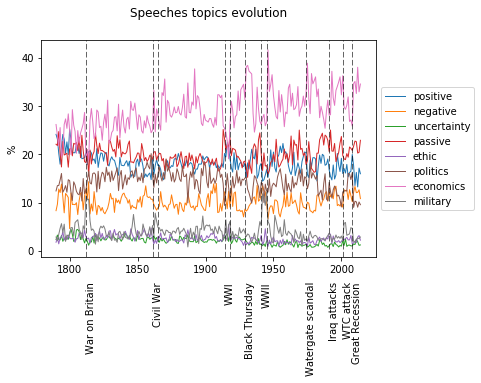

In [14]:
us_dates = [1812,1861,1865,1914,1918,1929,1941,1945, 1974,1991,2001,2008]
us_dates_exp = ['War on Britain','Civil War','','WWI','', 'Black Thursday','WWII','','Watergate scandal','Iraq attacks','WTC attack', 'Great Recession']

X = ytp['year']
Y1 = ytp['pos'];Y2= ytp['neg'];Y3 = ytp['unc'];Y4= ytp['passive']
Y5 = ytp['ethic'];Y6= ytp['polit'];Y7 = ytp['econ']; Y8= ytp['milit']
plt.plot(X, Y1,   lw = 1., label = 'positive')
plt.plot(X, Y2, lw = 1., label = 'negative')
plt.plot(X, Y3, lw = 1., label = 'uncertainty')
plt.plot(X, Y4, lw = 1., label = 'passive')
plt.plot(X, Y5, lw = 1., label = 'ethic')
plt.plot(X, Y6,  lw = 1., label = 'politics')
plt.plot(X, Y7,  lw = 1., label = 'economics')
plt.plot(X, Y8,  lw = 1., label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i],linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-8,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Notice we have marked important historical US dates that hopefully will somewhat be related with the content of the yearly president speeches. In order to see more clearly what is going on with the topic time series, we will disagreggate the previous plot for 4 different time periods: 

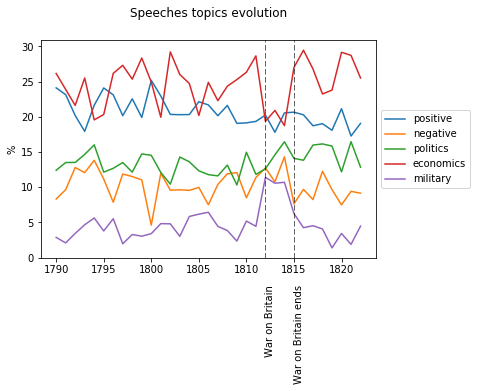

In [15]:
us_dates = [1812, 1815]
us_dates_exp = ['War on Britain', 'War on Britain ends']
plt.plot(X[0:33], Y1[0:33],   lw = 1.5, label = 'positive')
plt.plot(X[0:33], Y2[0:33], lw = 1.5, label = 'negative')
#plt.plot(X[0:33], Y3[0:33], lw = 1.5, label = 'uncertainty')
#plt.plot(X[0:33], Y4[0:33], lw = 1.5, label = 'passive')
#plt.plot(X[0:33], Y5[0:33], lw = 1.5, label = 'ethics')
plt.plot(X[0:33], Y6[0:33],  lw = 1.5, label = 'politics')
plt.plot(X[0:33], Y7[0:33],  lw = 1.5, label = 'economics')
plt.plot(X[0:33], Y8[0:33],  lw = 1.5, label = 'military')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-5,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/1820s.png', bbox_inches='tight')

plt.show()

The US-Britain war (aka The War of 1812) was a military conflict that lasted from June 1812 to February 1815, fought between the United States of America and the United Kingdom, its North American colonies, and its Native American allies. 
We can see that during this period yearly speeches were more military oriented and less economics oriented, which really makes if you're the president of a country on war. 

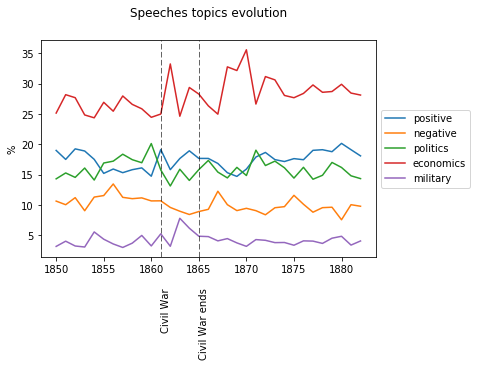

In [16]:
us_dates = [1861,1865]
us_dates_exp = ['Civil War','Civil War ends']
plt.plot(X[60:93], Y1[60:93],   lw = 1.5, label = 'positive')
plt.plot(X[60:93], Y2[60:93], lw = 1.5, label = 'negative')
#plt.plot(X[60:93], Y3[60:93], lw = 1.5, label = 'uncertainty')
#plt.plot(X[60:93], Y4[60:93], lw = 1.5, label = 'passive')
#plt.plot(X[60:93], Y5[60:93], lw = 1.5, label = 'ethics')
plt.plot(X[60:93], Y6[60:93],  lw = 1.5, label = 'politics')
plt.plot(X[60:93], Y7[60:93],  lw = 1.5, label = 'economics')
plt.plot(X[60:93], Y8[60:93],  lw = 1.5, label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-5,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/1850s.png', bbox_inches='tight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

The American Civil War was an internal conflict fought in the United States (U.S.) from 1861 to 1865. The Union (i.e., The United States) faced secessionists in eleven Southern states grouped together as the Confederate States of America. The Union won the war, which remains the bloodiest in U.S. history.

Again, speeches are more militar oriented and economic terms are very dominant in the speeches, experiencing an increase of frequency during this period. The American Civil War had a very strong economic background as Southern whites believed that the emancipation of slaves would destroy the South's economy, due to the large amount of capital invested in slaves and fears of integrating the ex-slave black population, p.e. 

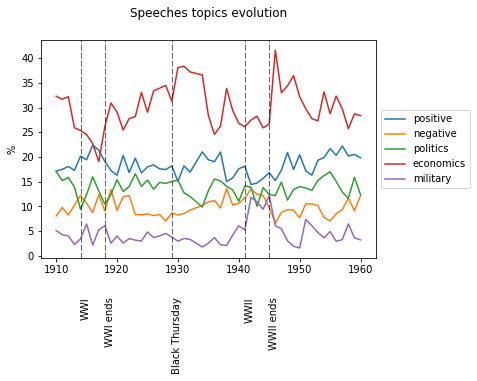

In [17]:
us_dates = [ 1914,1918,1929,1941,1945]
us_dates_exp = ['WWI','WWI ends', 'Black Thursday','WWII','WWII ends']
plt.plot(X[120:170], Y1[120:170],   lw = 1.5, label = 'positive')
plt.plot(X[120:170], Y2[120:170], lw = 1.5, label = 'negative')
#plt.plot(X[120:170], Y3[120:170], lw = 1.5, label = 'uncertainty')
#plt.plot(X[120:170], Y4[120:170], lw = 1.5, label = 'passive')
#plt.plot(X[120:170], Y5[120:170], lw = 1.5, label = 'ethics')
plt.plot(X[120:170], Y6[120:170],  lw = 1.5, label = 'politics')
plt.plot(X[120:170], Y7[120:170],  lw = 1.5, label = 'economics')
plt.plot(X[120:170], Y8[120:170], lw = 1.5, label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-10,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/interest1900s.png', bbox_inches='tight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

During the first half of the 90's speechecs became more and more economy-related. It is interesting to compare the composition of speeches in the First World War (1914-1918) with that in the Second World War (1941-1945). 
The United States declared war on Germany on April 6, 1917, during World War I. The U.S. was an independent power and did not officially join the Allies. It closely cooperated with them militarily but acted alone in diplomacy. This explains why, while a war was taking place, presidential speeches didn't become more military nor economically oriented but remained mainly as positive speeches. 

On the other hand, in the Second World War patriotism became the central theme of advertising throughout the war, as large scale campaigns were launched to sell war bonds, promote efficiency in factories, reduce ugly rumors, and maintain civilian morale. The media cooperated and the federal government presented the official view of the war. This can be clearly seen as speeches were mainly about military and during war were increasingly more positive and less negative to give courage to the population.

The Black Tuesday (or The Wall Street Crash), began on October 24 1929 and was the most devastating stock market crash in the history of the United States, and signaled the beginning of the 12-year Great Depression that affected all Western industrialized countries. Compromising the following years presidential speeches to be even more economics-related than before. 

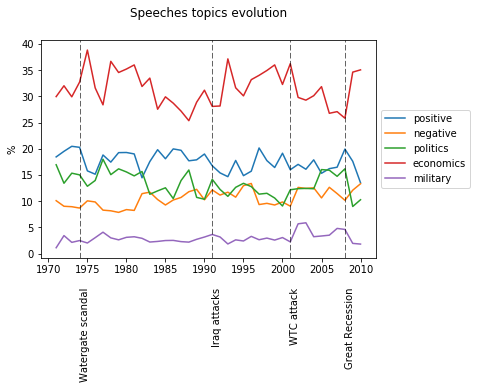

In [18]:
us_dates = [ 1974,1991,2001,2008]
us_dates_exp = ['Watergate scandal','Iraq attacks','WTC attack', 'Great Recession']
plt.plot(X[180:220], Y1[180:220],   lw = 1.5, label = 'positive')
plt.plot(X[180:220], Y2[180:220], lw = 1.5, label = 'negative')
#plt.plot(X[180:220], Y3[180:220], lw = 1.5, label = 'uncertainty')
#plt.plot(X[180:220], Y4[180:220], lw = 1.5, label = 'passive')
#plt.plot(X[180:220], Y5[180:220], lw = 1.5, label = 'ethics')
plt.plot(X[180:220], Y6[180:220],  lw = 1.5, label = 'politics')
plt.plot(X[180:220], Y7[180:220],  lw = 1.5, label = 'economics')
plt.plot(X[180:220], Y8[180:220], lw = 1.5, label = 'military')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-8,us_dates_exp[i],rotation=90)
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/2000s.png', bbox_inches='tight')
plt.ylabel('%')


plt.show()


The immediate years after the unfortunate events that took place during 1970-2010, Watergate scandal, Iraq attacks, World Trade Center attach, and the Great Recession; speeches became less positive and more negative. 

After Iraq attacks, speeches didn't become more military oriented but less, as it was an offensive strategy of war on another land. However, after the World Trade Center attack where US was the victim speeches became very military-oriented as this attach would lead into more war-strategies.

Again, after the Great Economic Recession speeches became more economic-oriented, less positive and more negative.

### 2. c)
We are interested in finding some correlations between relevant US time series and the addresses. We will study two different time series: unemployment in the US and US average interest rate in the period (1948 - 2010). We expect to find that unemployment is positively correlated with uncertainty in this period, whereas average interest rate should be negatively correlated. 

In [19]:
from scipy.stats.stats import pearsonr

uncert= ytp[ytp.year >= 1948].unc.reset_index(drop=True).values; posit= ytp[ytp.year >= 1948].pos.reset_index(drop=True).values
negat= ytp[ytp.year >= 1948].neg.reset_index(drop=True).values; passive= ytp[ytp.year >= 1948].passive.reset_index(drop=True).values
econ= ytp[ytp.year >= 1948].econ.reset_index(drop=True).values; polit= ytp[ytp.year >= 1948].polit.reset_index(drop=True).values
milit= ytp[ytp.year >= 1948].milit.reset_index(drop=True).values


In [20]:
''' unemployment'''
file = pd.read_table("./timeseries/annual_unemployment.txt",header=None)
unempl = pd.DataFrame(file[1]); unempl = unempl[1].values

corr_unempl = [pearsonr(unempl, uncert), pearsonr(unempl, posit),pearsonr(unempl, negat),
                pearsonr(unempl, passive) ,pearsonr(unempl, econ),pearsonr(unempl, polit),pearsonr(unempl, milit) ] 
corr_unempl = pd.DataFrame(corr_unempl)
corr_unempl[2] = ['uncertainty', 'positive', 'negative', 'passive', 'economy', 'politics', 'military']; corr_unempl.columns = ('unempl corr', 'p-val','topic')
corr_unempl

,unempl corr,p-val,topic
0,0.117741,0.342659,uncertainty
1,-0.311381,0.010320,positive
2,0.330950,0.006228,negative
3,0.052117,0.675326,passive
4,0.287207,0.018446,economy
5,-0.283081,0.020275,politics
6,-0.336682,0.005339,military


Correlation between unemployment and uncertainty in the US during 1948-2010 is positive as we expected, however from the p-value we see that such correlation is not significant. Also we have computed the correlation with the other topics. 

In [21]:

'''inflation rate'''
file2 = pd.read_table("./timeseries/inflation_rate.txt",header=None)
infl = file2[file2[0]>=1948].reset_index(drop=True); infl = pd.DataFrame(infl[1]); infl = infl[1].values

corr_infl = [pearsonr(infl, uncert), pearsonr(infl, posit),pearsonr(infl, negat),
                pearsonr(infl, passive) ,pearsonr(infl, econ),pearsonr(infl, polit),pearsonr(infl, milit) ] 
corr_infl = pd.DataFrame(corr_infl)
corr_infl[2] = ['uncertainty', 'positive', 'negative', 'passive', 'economy', 'politics', 'military']; corr_infl.columns = ('infl corr', 'p-val','topic')
corr_infl

,infl corr,p-val,topic
0,-0.213626,0.082599,uncertainty
1,0.091885,0.459588,positive
2,-0.260838,0.033013,negative
3,-0.293544,0.015912,passive
4,0.156760,0.205215,economy
5,0.292166,0.016436,politics
6,-0.042462,0.732970,military


Correlation between inflation rate and uncertainty is negative as expected, and such correlation is significant. 

### 2. d)
Using the same dictionaries we now want to compute the content of each yearly-document using term weighting instead of document-topic counts as we have already done. Because in Exercise 2.b) we didn't show top topic document rankings, we will do now for both dt scoring and tf-idf scoring, comparing the results and checking that top year-docs obained with this method coincides with what we obtained in the code previously shown. 

In [22]:
from collections import OrderedDict

def ranking(stemmed,data,dictionary, use_tf_idf, n):
    # From DT matrix/TF-IDF matrix and a vocabulary, gets rid of words not appearing in the dictionary,
    # computes the total frequency/weighted count for each doc (or year) and orders the docs by scoring
    vocab = get_vocab(stemmed)
    dt_matrix = make_count(stemmed)
    tfidf_matrix = make_TF_IDF(stemmed)

    if (use_tf_idf):
        dtm = tfidf_matrix
    else:
        dtm = dt_matrix

    dict_tokens_set = set(item for item in dictionary)
    intersection = list(set(dict_tokens_set) & set(vocab))
    vec_positions = [int(token in intersection) for token in vocab] 

    sums = np.zeros(len(dtm))
    for j in range(len(dtm)):
        sums[j] = sum([a * b for a, b in zip(dtm[j], vec_positions)])
        #this sums vector is equal to the column of the given dictionary of the docs-dict matrix we obtain with docs_dict_matrix()
        order = sorted(range(len(sums)), key = lambda k: sums[k], reverse=True)
    ordered_year_data_n = [None] * len(dtm)
    ordered_sums = np.zeros(len(dtm))

    counter = 0        
    for num in order:
        ordered_year_data_n[counter] = data.year[num]
        ordered_sums[counter] = sums[num]
        counter += 1

    return list((ordered_year_data_n[0:n], ordered_sums[0:n]))


We proceed to rank top 5 year for each topic/dictionary and for both scoring methods, dt and tf-idf.

In [23]:
n_rank = 5

# dt score
pos_sorted_years,pos_tf_score = ranking(stemmed_y, processed_data_y, positive_dict, False, n_rank) 
neg_sorted_years,neg_tf_score = ranking(stemmed_y, processed_data_y, negative_dict, False, n_rank) 
et_sorted_years,et_tf_score = ranking(stemmed_y, processed_data_y, ethic_dict, False, n_rank) 
pol_sorted_years,pol_tf_score = ranking(stemmed_y, processed_data_y, politic_dict, False, n_rank) 
ec_sorted_years,ec_tf_score = ranking(stemmed_y, processed_data_y, econ_dict, False, n_rank) 
mil_sorted_years,mil_tf_score = ranking(stemmed_y, processed_data_y, military_dict, False, n_rank) 
unc_sorted_years,unc_tf_score = ranking(stemmed_y, processed_data_y, uncert_dict, False, n_rank) 
pas_sorted_years,pas_tf_score = ranking(stemmed_y, processed_data_y, passive_dict, False, n_rank) 

# tf-idf score
ipos_sorted_years,ipos_tf_score = ranking(stemmed_y, processed_data_y, positive_dict,True,n_rank) 
ineg_sorted_years,ineg_tf_score = ranking(stemmed_y, processed_data_y, negative_dict,True,n_rank) 
iet_sorted_years,iet_tf_score = ranking(stemmed_y, processed_data_y, ethic_dict,True,n_rank) 
ipol_sorted_years,ipol_tf_score = ranking(stemmed_y, processed_data_y, politic_dict,True,n_rank) 
iec_sorted_years,iec_tf_score = ranking(stemmed_y, processed_data_y, econ_dict,True,n_rank) 
imil_sorted_years,imil_tf_score = ranking(stemmed_y, processed_data_y, military_dict,True,n_rank) 
iunc_sorted_years,iunc_tf_score = ranking(stemmed_y, processed_data_y, uncert_dict,True,n_rank) 
ipas_sorted_years,ipas_tf_score = ranking(stemmed_y, processed_data_y, passive_dict,True,n_rank) 

/home/euan/.local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [24]:
print ("Top 5 economics years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(ec_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(ec_sorted_years[i], ec_tf_score[i],iec_sorted_years[i], iec_tf_score[i])) 


Top 5 economics years
    DT        TFIDF
1790 nan 1981 14665.982642290524  
1791 nan 1980 13966.89553362941  
1981 4588.0 1946 11889.712847266392  
1980 4338.0 1979 9312.452100451734  
1946 3633.0 1974 8993.670164124183  


Both methods agree in the top 5 economic years raking, although obviously giving different scores, 

In [25]:
print ("Top 5 positive years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(pos_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(pos_sorted_years[i], pos_tf_score[i],ipos_sorted_years[i], ipos_tf_score[i])) 


Top 5 positive years
    DT        TFIDF
1981 2423.0 1981 9420.802570473896  
1980 2376.0 1980 9285.874673941962  
1974 1712.0 1974 6672.132614985524  
1979 1613.0 1979 6396.767870382075  
1907 1404.0 1907 5542.863064747849  


DT and TF-IDF scoring give the same top 2 positivie years, being 1981 and 1980, but differ for the rest of the ranking.

In [26]:
print ("Top 5 negative years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(neg_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(neg_sorted_years[i], neg_tf_score[i],ineg_sorted_years[i], round(ineg_tf_score[i],1))) 


Top 5 negative years
    DT        TFIDF
1790 nan 1981 3906.2  
1791 nan 1980 3842.8  
1794 nan 1906 3546.2  
1795 1.7201409965685603e+308 1907 3499.9  
1796 2.964056480142662e+306 1905 3182.8  


Funny enough, top 2 negative years are 1981, both scoring methods agreeing. With this dictionary, they even agree in the top 5 years but changing the order. 

In [27]:
print ("Top 5 politics years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(pol_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(pol_sorted_years[i], pol_tf_score[i],ipol_sorted_years[i], ipol_tf_score[i])) 


Top 5 politics years
    DT        TFIDF
1790 nan 1980 8460.027339456414  
1791 nan 1981 8013.34598582039  
1980 1919.0 1979 5932.09385163162  
1981 1889.0 1910 5406.311212040278  
1979 1354.0 1974 5369.236126113528  


Top 2 politics years are 1981, both scoring methods agreeing. With this dictionary, they even agree in the top 5 years but changing the order. 

In [28]:
print ("Top 5 military years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(mil_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(mil_sorted_years[i], mil_tf_score[i],imil_sorted_years[i], imil_tf_score[i])) 


Top 5 military years
    DT        TFIDF
1790 nan 1946 2279.6366402041267  
1791 nan 1898 1716.922542933589  
1946 531.0 1910 1683.1487945865372  
1945 412.0 1907 1644.9116848210315  
1981 408.0 1945 1561.1955480357105  


Regarding military year ranking, where the counting frequency is much smaller compared to using other dictionaries, the two different methods disagree in every year of the ranking.

In [29]:
print ("Top 5 ethics years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(et_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(et_sorted_years[i], et_tf_score[i],iet_sorted_years[i], iet_tf_score[i])) 



Top 5 ethics years
    DT        TFIDF
1790 nan 1906 1067.5370287660307  
1791 nan 1905 939.7886993921159  
1906 270.0 1845 880.676351671398  
1905 242.0 1860 794.671739108666  
1845 208.0 1907 790.4827221045363  


Both scoring methods only agree in the top 2 ethics years.

In [30]:
print ("Top 5 uncertainty years")
print ("   " , "DT", "     "    , " TFIDF")
for i in range(len(unc_sorted_years)):
    print ("{0} {1} {2} {3}  ".format(unc_sorted_years[i], unc_tf_score[i],iunc_sorted_years[i], iunc_tf_score[i])) 


Top 5 uncertainty years
    DT        TFIDF
1790 nan 1848 651.2258390301848  
1791 nan 1906 649.3702525448133  
1907 161.0 1911 630.316564926155  
1911 157.0 1907 594.204586999064  
1906 156.0 1885 588.5316658769847  


## Exercise 3

In [31]:
import sklearn
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [32]:
# Comparison of parties post 1860
# First collect names and assign parties to all presidents after first Republican president elected
pres    = sorted(list ( set(data.loc[data.year > 1860].president)))
party   = ['rep']*3 + ['dem']*3 + ['rep']*8 + ['dem']*3 + ['rep']*3 + ['dem']*1 + ['rep']*2 + ['dem'] + ['rep'] + ['dem']*2

pres_party = dict(zip(pres, party))

data_post1860 = data.loc[data.year > 1860]
parties = [pres_party[i] for i in data_post1860.president]
data_post1860 = data_post1860.assign(party=parties)

In [33]:
# Process data as in exercise 1
stemmed_post1860, processed_post1860 = data_processing(data_post1860)
stemmed_post1860 = custom_stopword_del(stemmed_post1860, our_stopwords)
stemmed_post1860, processed_post1860 = remove_zerolen_strings(stemmed_post1860, processed_post1860)

In [34]:
# Make indexes of which speech-paragraphs belong to each presidents of each party
parties_post1860 = [i for i in processed_post1860.party]
dem_idx = [i for i in range(len(parties_post1860)) if parties_post1860[i] == 'dem']
rep_idx = [i for i in range(len(parties_post1860)) if parties_post1860[i] == 'rep']

In [35]:
# Calculate tf-idf matrix
tf_idf_post1860 = make_TF_IDF(stemmed_post1860)

In [36]:
#calculate cosine similarity
cos_sim = cosine_similarity(tf_idf_post1860)

In [37]:
# Compare average cosine similarity within and between parties
similarity_within_dem = cos_sim[dem_idx,:][:,dem_idx]
similarity_within_rep = cos_sim[rep_idx,:][:,rep_idx]
similarity_between_parties = cos_sim[dem_idx,:][:,rep_idx]

In [38]:
print(np.mean(similarity_within_dem))
print(np.mean(similarity_within_rep))
print(np.mean(similarity_between_parties))

0.0167096029699
0.0200727235134
0.0172572995905


In [ ]:
print(np.mean(similarity_within_dem)/np.mean(similarity_between_parties))
print(np.mean(similarity_within_rep)/np.mean(similarity_between_parties))

0.968262901288
1.16314394428


Now we will perform latent semantic analysis (LSA) to see if this gives a clearer distinction between parties.

In [ ]:
# SVD
U, S, V = svds(tf_idf_post1860, k = 200)

In [ ]:
# Get low rank approximation of tf-idf matrix
low_rank_approx = U.dot(np.diag(S)).dot(V)

In [ ]:
# Cosine similarity
low_rank_cos_sim = cosine_similarity(low_rank_approx)

low_rank_similarity_within_dem = low_rank_cos_sim[dem_idx,:][:,dem_idx]
low_rank_similarity_within_rep = low_rank_cos_sim[rep_idx,:][:,rep_idx]
low_rank_similarity_between_parties = low_rank_cos_sim[dem_idx,:][:,rep_idx]

In [ ]:
print(np.mean(low_rank_similarity_within_dem))
print(np.mean(low_rank_similarity_within_rep))
print(np.mean(low_rank_similarity_between_parties))

In [ ]:
print(np.mean(low_rank_similarity_within_dem)/np.mean(low_rank_similarity_between_parties))
print(np.mean(low_rank_similarity_within_rep)/np.mean(low_rank_similarity_between_parties))

Interestingly, this analysis gives us that democrats are not much more similar to each other than they are to republicans, whereas republicans are much more similar to each other than they are to democrats. LSA here makes the distinction between parties somewhat clearer, as it provides more evidence of clustering of democrats, but less of clustering of republicans

## Exercise 4

In [ ]:
# E Step
def E_step(rho_i, B_i, count_matrix):
    L =  np.log(rho_i) + count_matrix.dot(np.log(B_i.T))
    z_hat = np.exp((L.T - logsumexp(L, axis=1)).T)
    return z_hat

In [ ]:
# M Step
def rho_update(z_hat, count_matrix):
    D = np.shape(count_matrix)[0]
    rho_i = np.sum(z_hat, axis = 0) / D
    return rho_i

def beta_update(z_hat, count_matrix, N_d):
    lower_bound =  10**(-100)
    B_i = (count_matrix.T.dot(z_hat) / np.sum(z_hat.T * N_d, axis=1)).T
    B_i[B_i <= lower_bound] = lower_bound
    return B_i

In [ ]:
# Calculate log-likelihood
def MM_loglik(rho_i, B_i, count_matrix):
    # Calculate log-likelihood of Multinomial Mixture Model
    L =  np.log(rho_i) + count_matrix.dot(np.log(B_i.T))
    L[L <= -500] = -500
    L =  np.exp(L)
    ll = np.sum(L, axis = 1)
    if ll.min() == 0.0:
        ll[ll==0.0] = np.finfo('float').max**(-1)
    ll = np.sum(np.log(ll))
    return(ll)

In [ ]:
def Multinom_Mixt_EM(data, k, max_iters = 100, eps = 10^(-3)):
    count_matrix = make_count(data)
    vocab = get_vocab(data)
    D = len(data)
    n = len(vocab)
    N_d = [len(x) for x in data]

    # Initialise params
    rho_i   = [1/k]*k
    B_i     = np.random.dirichlet([1]*n, size=k)
    loglik_seq = [MM_loglik(rho_i, B_i, count_matrix)]

    for i in range(max_iters):

        # E step
        z_hat   = E_step(rho_i, B_i, count_matrix)

        # M step
        rho_i   = rho_update(z_hat, count_matrix)
        B_i     = beta_update(z_hat,count_matrix, N_d)
        loglik_seq.append(MM_loglik(rho_i, B_i, count_matrix))

        # Early stopping criterion
        if (loglik_seq[len(loglik_seq) - 1] - loglik_seq[len(loglik_seq) - 2]) <= eps:
            return [z_hat, rho_i, B_i, loglik_seq]

    return [z_hat, rho_i, B_i, loglik_seq]

In [ ]:
z_hat, rho_i, B_i, loglik_seq = Multinom_Mixt_EM(stemmed, k=3, max_iters = 100)

In [ ]:
# Plot log-likelihood (starting from 20th iteration so scale is clearer)
plt.plot(loglik_seq[20:])
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')
plt.title('Multinomial Mixture Model EM Algorithm')
plt.show()

Note that the log-likelihood increases at each step. 